# Evaluate the model

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

from get_loader import get_loader
from models import Encoder, Decoder
import torch
import torch.nn as nn
from utils import *
from PIL import Image
from nltk.translate import bleu_score

In [2]:
IMAGE_PATH = '../Datasets/coco/images/val2017' 
CAPTIONS_PATH = '../Datasets/coco/annotations/' #captions_train2017.json'

FREQ_THRESHOLD = 5
CAPS_PER_IMAGE = 1
BATCH_SIZE = 1
SHUFFLE = True
MODE = 'test'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We are using {device}.")

We are using cuda.


## Model 3 - sports "v1"

This has same parameters as model 2, but data set is restricted to images showing sports categories.

Original model was run with vocab saved in:
* `sportsword2idx.json`

And model saved in:
* `model/model_sport_v2` folder


In [4]:
CAPTIONS_NAME = 'sports_v1'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 10k/2k/1k\n' \
                'frequency threshold: 5\n' \
                'batch size: 128\n' \
                'embed size: 1024'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v1'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 938.
Length of vocabulary: 2110


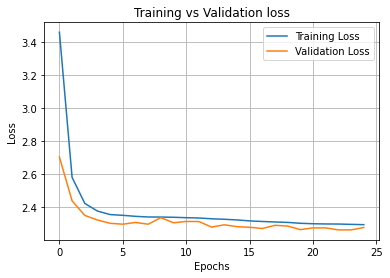

In [5]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

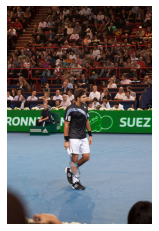

Predicted caption: a man is playing tennis on a court .
Original Captions:
0. a man plays tennis in front of a large audience
1. The tennis player is walking on the court.
2. A tennis player holding a racket during a tennis match.
3. A man in black shirt and white shorts on a tennis court.
4. Male tennis player on the middle of the court.


In [6]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [ ]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

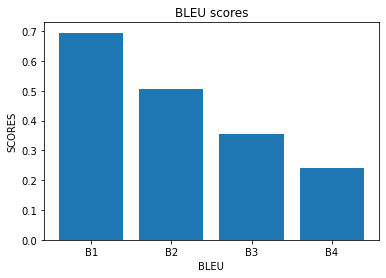

In [8]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [9]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

### The dreaded beam search

In [10]:
# from beam_search import BeamSearch

In [11]:
# encoder.to(device);
# encoder.eval()

# transformer = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
# ])

# img = transformer(img)
# img = img.to(device)

# features = encoder(img.unsqueeze(0)).unsqueeze(1)

In [12]:
# beam = BeamSearch(decoder=decoder,
#                   features=features,
#                   word2idx=word2idx,
#                   k=3, 
#                   max_len=20)

# sentence, score = beam.generate_caption()

## Model 4 - sports "v3"

Some adaptations to sports v2: embedding size down to 512 from 1024, a larger train set of 15k instead of 10k images, and a frequency theshold of 4 for inclusion in the vocab. Most models training on the full coco training set seem to use a frequency threshold of 5, so we thought trying a threshold of 4 was worth while given that we're using 15k instead of 128k images as the training set.

Original model was run with vocab saved in:
* `sports_v2word2idx.json`

And model saved in:
* `model/model_sport_v3` folder


In [7]:
CAPTIONS_NAME = 'sports_v2'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 4\n' \
                'batch size: 128\n' \
                'embed size: 512' 
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v3'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 938.
Length of vocabulary: 2921


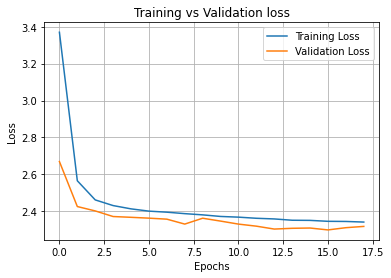

In [8]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

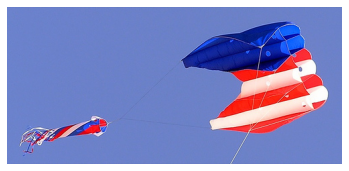

Predicted caption: a kite flying a kite in a field .
Original Captions:
0. a patriotic kite flying through the clear blue sky.
1. A red, white, and blue kite sails through the blue sky.
2. The kite is red, white, and blue and is flying.
3. Two red, white and blue kites flying in the sky.
4. A red, white and blue kit flying among the sky.


In [9]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [10]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 1s, sys: 13.5 s, total: 3min 15s
Wall time: 50 s


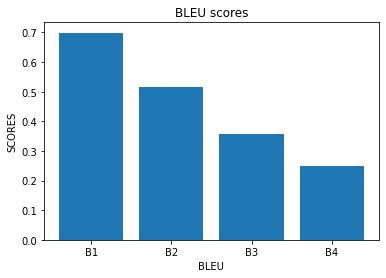

In [11]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [18]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 5 - sports_v4

This has same parameters as model 2, but data set is restricted to images showing sports categories.

In [44]:
CAPTIONS_NAME = 'sports_v4'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 15k/2k/2k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512\n' \
                'vocab build using entire train2017 captions data'
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v4'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 938.
Length of vocabulary: 10192


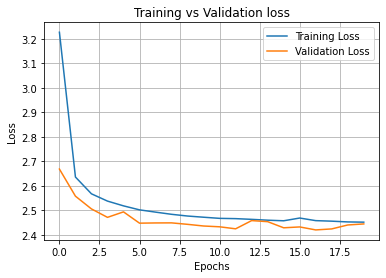

In [45]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

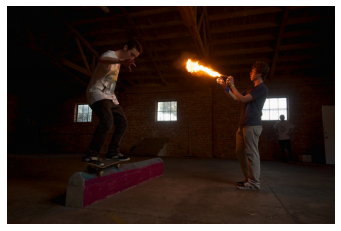

Predicted caption: a man riding a skateboard on a skateboard .
Original Captions:
0. A teenager shoots flames at a friend balancing on a skateboard.
1. a man rides his skateboard on a small ledge while another man lights the spray from a can on fire
2. A skateboarder on a rail in a  building with another man using a spray can as a blow torch.
3. A man ignites spray from a can next to his friend on a skateboard
4. The young man is practicing his tricks on his skateboard while the other is playing with fire.


In [46]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [22]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 51s, sys: 14.1 s, total: 4min 5s
Wall time: 1min 1s


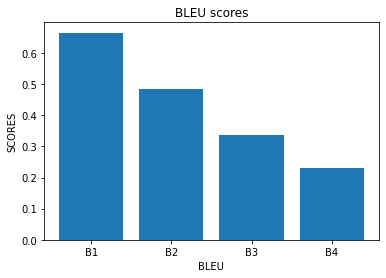

In [23]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [24]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 6 - sports_v5

All the sport data - 28k training size.

In [47]:
CAPTIONS_NAME = 'sports_v5'
MODEL_SUMMARY = 'only images containing objects from sports super-category.\n' \
                'train/val/test size 20k/3k/1k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 1024'   
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_v5'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 938.
Length of vocabulary: 2988


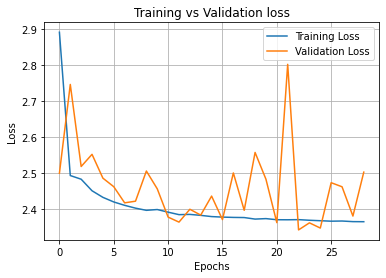

In [48]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

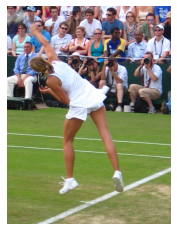

Predicted caption: a man is playing with a frisbee in the air .
Original Captions:
0. A woman swinging a tennis racquet on a tennis court.
1. A woman jumping in the air on the tennis court
2. a women that is playing tennis on a court
3. There is a woman jumping in the area during a tennis game.
4. Her long legs propel her high enough to hit the tennis ball.


In [27]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [28]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 2min 9s, sys: 7.48 s, total: 2min 17s
Wall time: 34.6 s


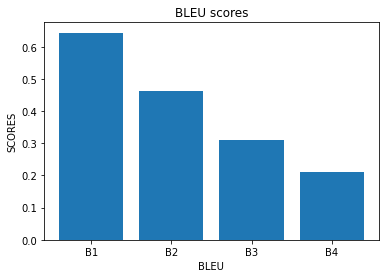

In [29]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [30]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 7 - everything

This has same parameters as model 2, but data set is restricted to images showing sports categories.

In [12]:
CAPTIONS_NAME = 'everything'
MODEL_SUMMARY = 'images sampled from entire train2017 data set\n' \
                'train/val/test size 102k/15k/5k\n' \
                'frequency threshold: 5\n' \
                'batch size: 64\n' \
                'embed size: 512'    
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_everything'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 4952.
Length of vocabulary: 10192


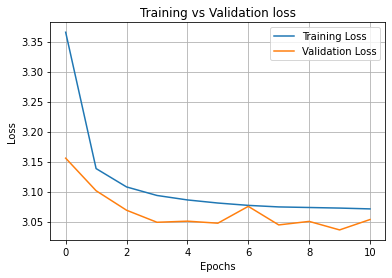

In [13]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

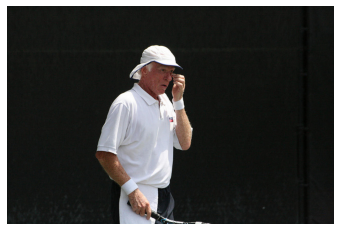

Predicted caption: a man is holding a tennis bat on a tennis court .
Original Captions:
0. A man with a tennis racquet is dressed in white.
1. an image of a man that is wiping his eye
2. A man in white shirt and hat holding a tennis racket.
3. A man holding a tennis racket picks rubs his eye.
4. The older man is playing tennis on the court. 


In [14]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [7]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 14min 47s, sys: 59 s, total: 15min 46s
Wall time: 4min 5s


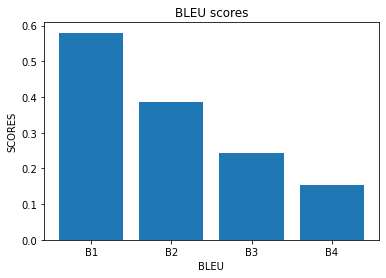

In [8]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [9]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Model 7 - sports "v2" but with modified encoder.

Our encoder has two fully connected layers at the end. We ran this model to compare with a more traditional architecture where you remove the last fc resnet layer and replace with just one layer. 

The training speed and final results are almost identical.

In [6]:
CAPTIONS_NAME = 'sports_encoder'
MODEL_SUMMARY = 'images sampled from entire train2017 data set\n' \
                'train/val/test size 15k/2k/1k\n' \
                'frequency threshold: 4\n' \
                'batch size: 128\n' \
                'embed size: 512'    
captions_path = CAPTIONS_PATH + f'{CAPTIONS_NAME}_captions_test.json'
# idx2word_path = '../vocabulary/idx2word.json' # not needed any more
word2idx_path = f'../vocabulary/{CAPTIONS_NAME}word2idx.json'

# Load the vocab
idx2word, word2idx = load_vocab(word2idx_path=word2idx_path)

CHECKPOINT = '../model/model_sport_encoder'
param_3 = load_params(CHECKPOINT)

test_loader_params = {
    'images_path': IMAGE_PATH,
    'captions_path': captions_path,
    'freq_threshold': FREQ_THRESHOLD,
    'caps_per_image': CAPS_PER_IMAGE,
    'batch_size': BATCH_SIZE,
    'shuffle': SHUFFLE,
    'mode': MODE,
    # 'idx2word': idx2word,
    'word2idx': word2idx
}

test_loader, test_dataset = get_loader(**test_loader_params)

print(f"Length of testing dataloader: {len(test_loader)}.")
print(f"Length of vocabulary: {len(test_dataset.vocab.idx2word)}")

Length of testing dataloader: 938.
Length of vocabulary: 2921


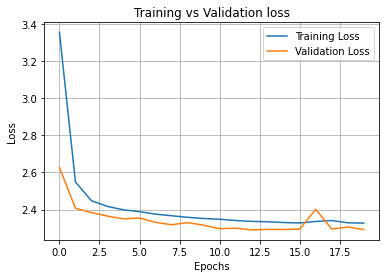

In [7]:
# for encoder and decoder
EMBED_SIZE = param_3['embed_size'] # dimension of vocab embedding vector
HIDDEN_SIZE = param_3['hidden_size']
NUM_LAYERS = param_3['num_layers'] #hidden layers in LTSM
vocab_size = param_3['vocab_size']

encoder = Encoder(embed_size=EMBED_SIZE, pretrained=True)
decoder = Decoder(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS)

epoch, encoder, decoder, training_loss, validation_loss = load_model(encoder, decoder, CHECKPOINT)

plot_loss(training_loss, validation_loss)

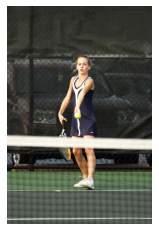

Predicted caption: a man holding a tennis racket on a tennis court .
Original Captions:
0. A tennis player getting ready to serve the ball 
1. A young woman on a tennis court preparing to serve the ball. 
2. A little girl on a tennis court that has a racquet.
3. A girl is playing tennis and is going to pitch the ball. 
4. woman in tennis garb preparing to serve tennis ball


In [8]:
idx, images, captions = next(iter(test_loader))
img = test_dataset.get_img(idx[0])
plt.imshow(img)
hypo = predict(encoder, decoder, img, test_dataset.vocab.idx2word, test_dataset.vocab.word2idx,device)
references = test_dataset.get_captions(test_dataset.img_deque[idx[0]][0])

print(f"Predicted caption: {hypo}")
print("Original Captions:")
for i in range(len(references)):
    print(f"{i}. {references[i]}")

In [9]:
%%time
# Evaluate the model using BLEU Scores
evaluation_params = {
    'encoder': encoder,
    'decoder': decoder,
    'loader': test_loader, 
    'dataset': test_dataset,
    'device': device
}
b1, b2, b3, b4 = evaluate_bleu_score(**evaluation_params)

CPU times: user 3min 8s, sys: 11.5 s, total: 3min 19s
Wall time: 50.4 s


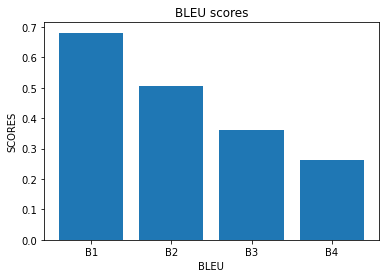

In [10]:
plot_bleu_score_bar(b1, b2, b3, b4)

In [11]:
bleu_score = [b1, b2, b3, b4]
save_results(CAPTIONS_NAME, CHECKPOINT, MODEL_SUMMARY, training_loss, validation_loss, bleu_score)

## Comparing the models

In [38]:
model_paths = ['../model/model_v1', '../model/model_v2']
compare_models_losses(model_paths)

AssertionError: Folder not found

In [ ]:
bleu_scores = [ [b1_0, b2_0, b3_0, b4_0], [b1, b2, b3, b4]]
comparing_bleu_scores(bleu_scores)

In [15]:
encoder

Encoder(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [16]:
encoder.resnet.fc.in_features

2048